# Build model using transfer learning InceptionV3

In [18]:
# Requirement Lib Import
import os
import random
import tensorflow as tf
from tensorflow import keras

In [19]:
# Check GPU support and Get GPU device
from tensorflow.python.client import device_lib 

try:
    print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
    print(device_lib.list_local_devices())
except:
      print('No GPU devices found!')

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1582924807511473745
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2914163099
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8512168030257986251
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [27]:
# Set default desired model input shape size
INPUT_SIZE = (80, 80)

In [28]:
# List path locations
BASE_PATH = './dataset'
BASE_DATASET_PATH = os.path.join(BASE_PATH, 'hand-sign-bisindo', 'anoted')
BASE_DATASET_EXT_PATH = os.path.join(BASE_PATH, 'hand-sign-bisindo', 'extracted')

TRAIN_DATASET_PATH = os.path.join(BASE_DATASET_EXT_PATH, 'train')
VALIDATION_DATASET_PATH = os.path.join(BASE_DATASET_EXT_PATH, 'val')
TEST_DATASET_PATH = os.path.join(BASE_DATASET_EXT_PATH, 'test')

In [29]:
static_labels = os.listdir(TRAIN_DATASET_PATH)

for label in static_labels:
    print('Total TRAINING \'{}\' Images:'.format(label), len(os.listdir(os.path.join(TRAIN_DATASET_PATH, label))))

Total TRAINING 'A' Images: 192
Total TRAINING 'B' Images: 140
Total TRAINING 'C' Images: 106
Total TRAINING 'D' Images: 188
Total TRAINING 'E' Images: 160
Total TRAINING 'F' Images: 147
Total TRAINING 'G' Images: 152
Total TRAINING 'H' Images: 164
Total TRAINING 'I' Images: 170
Total TRAINING 'J' Images: 96
Total TRAINING 'K' Images: 140
Total TRAINING 'L' Images: 101
Total TRAINING 'M' Images: 131
Total TRAINING 'N' Images: 153
Total TRAINING 'O' Images: 248
Total TRAINING 'P' Images: 170
Total TRAINING 'Q' Images: 136
Total TRAINING 'R' Images: 148
Total TRAINING 'S' Images: 164
Total TRAINING 'T' Images: 146
Total TRAINING 'U' Images: 242
Total TRAINING 'V' Images: 175
Total TRAINING 'W' Images: 124
Total TRAINING 'X' Images: 144
Total TRAINING 'Y' Images: 154
Total TRAINING 'Z' Images: 149


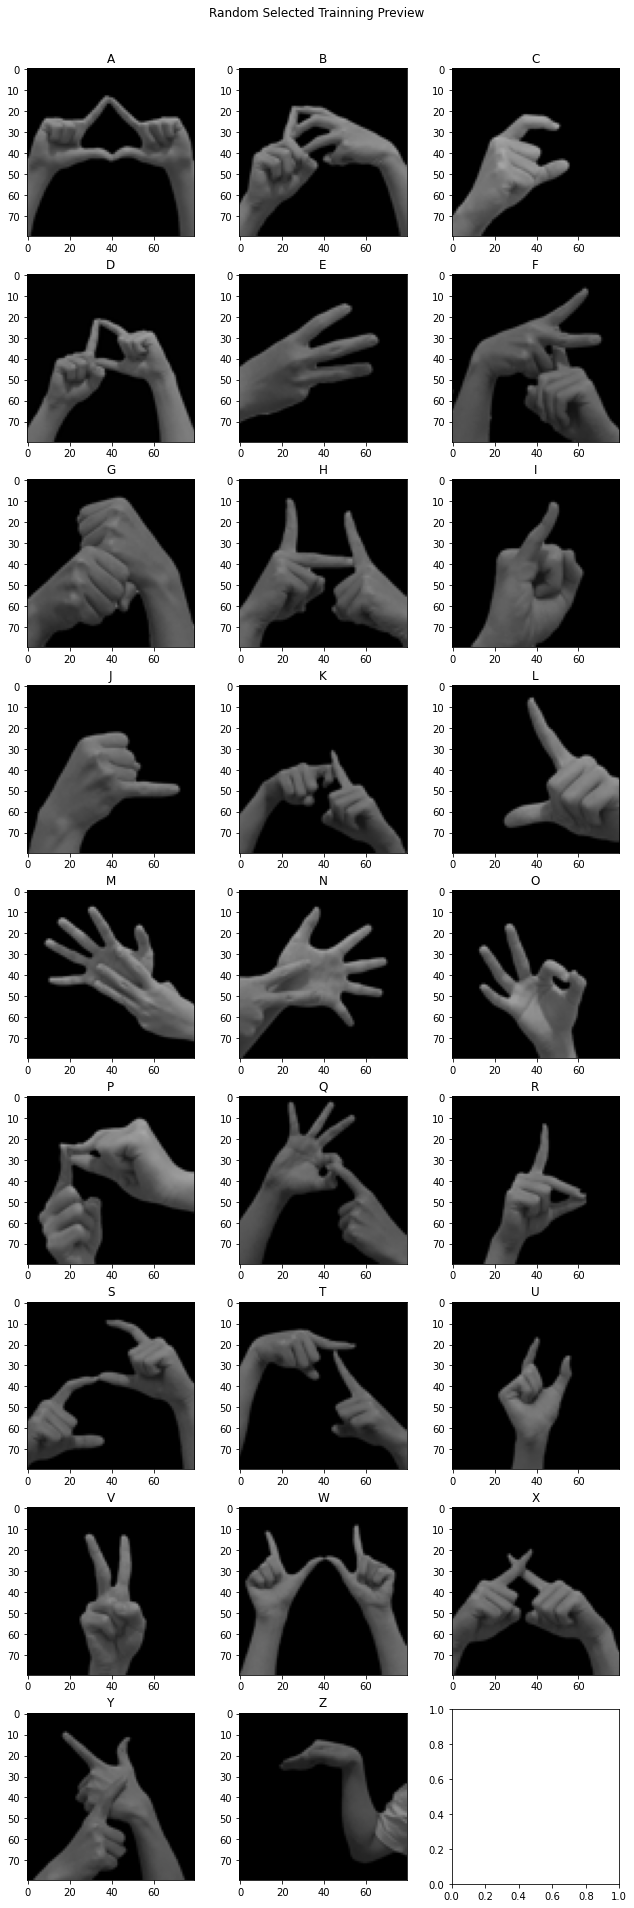

In [30]:
# Requirement Lib Import
import math
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Random seed
seed = random.randint(0, 42)

# plot matrix size
cols = 3
rows = math.ceil(len(static_labels) / 3)

# Show image plot
fig_size = 3
fig, axs = plt.subplots(rows, cols, figsize = ((fig_size * cols), (fig_size * rows)))
fig.suptitle('Random Selected Trainning Preview')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)
axs = axs.ravel()

# Image training random selector
img_dict = {}
for idx, label in enumerate(static_labels):
    img_path = os.path.join(TRAIN_DATASET_PATH, label)
    img_rand = os.listdir(img_path)[seed]
    img_selc = image.load_img(os.path.join(img_path, img_rand))

    axs[idx].imshow(img_selc.resize(INPUT_SIZE))
    axs[idx].set_title(label)

In [31]:
# Dataset pre-processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
validation_datagen = ImageDataGenerator(rescale = 1 / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATASET_PATH,
    target_size = INPUT_SIZE,
    class_mode = 'categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATASET_PATH,
    target_size = INPUT_SIZE,
    class_mode = 'categorical'
)

Found 4040 images belonging to 26 classes.
Found 497 images belonging to 26 classes.


In [32]:
# defined classes based on foldering structure, sort by alphabetical
LABELS = list(train_generator.class_indices.keys())
NUM_CLASSES = len(LABELS) # Set classes num
print(NUM_CLASSES)

26


In [33]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    weights = 'imagenet', 
    input_shape = (INPUT_SIZE[0], INPUT_SIZE[1], 3), 
    include_top = False, 
    pooling = 'avg'
)

for layer in pre_trained_model.layers:
    layer.trainable = False

# See Pre Trained Model Summary
pre_trained_model.summary()

ling2d_6[0][0]        
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 3, 3, 192)    576         conv2d_64[0][0]                  
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 3, 3, 192)    576         conv2d_67[0][0]                  
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 3, 3, 192)    576         conv2d_72[0][0]                  
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 3, 3, 192)    576         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 3, 3, 192)    0           batch_normalization_6

In [38]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 768)


In [43]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
# More info about Adam optimzer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(NUM_CLASSES, activation = 'softmax')(x)  

# Re-Create model
model = Model(inputs = pre_trained_model.input, outputs = x)

# Compile Model
model.compile(
    optimizer = Adam(learning_rate = 0.001), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

# Start Training!
history = model.fit(
    train_generator, 
    validation_data = validation_generator, 
    steps_per_epoch = 50,
    epochs = 20, 
    validation_steps = 10,
    verbose = 1
)

Epoch 1/20
50/50 [==============================] - 11s 169ms/step - loss: 2.2804 - accuracy: 0.4750 - val_loss: 0.4831 - val_accuracy: 0.8438
Epoch 2/20
50/50 [==============================] - 8s 159ms/step - loss: 0.8895 - accuracy: 0.7325 - val_loss: 0.3001 - val_accuracy: 0.9156
Epoch 3/20
50/50 [==============================] - 8s 162ms/step - loss: 0.7722 - accuracy: 0.7716 - val_loss: 0.2276 - val_accuracy: 0.9438
Epoch 4/20
50/50 [==============================] - 8s 158ms/step - loss: 0.6571 - accuracy: 0.8138 - val_loss: 0.1366 - val_accuracy: 0.9594
Epoch 5/20
50/50 [==============================] - 8s 152ms/step - loss: 0.5599 - accuracy: 0.8294 - val_loss: 0.1486 - val_accuracy: 0.9531
Epoch 6/20
50/50 [==============================] - 8s 162ms/step - loss: 0.4055 - accuracy: 0.8712 - val_loss: 0.0917 - val_accuracy: 0.9812
Epoch 7/20
50/50 [==============================] - 8s 151ms/step - loss: 0.3721 - accuracy: 0.8883 - val_loss: 0.0959 - val_accuracy: 0.9750
Epoch

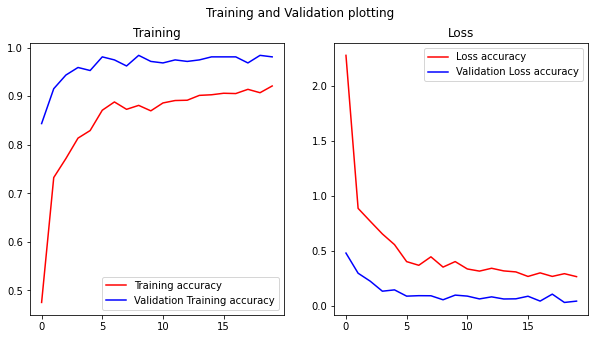

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Training and Validation plotting')
axs[0].plot(epochs, acc, 'r', label = 'Training accuracy')
axs[0].plot(epochs, val_acc, 'b', label = 'Validation Training accuracy')
axs[0].set_title('Training')
axs[0].legend()
axs[1].plot(epochs, loss, 'r', label = 'Loss accuracy')
axs[1].plot(epochs, val_loss, 'b', label = 'Validation Loss accuracy')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()

In [45]:
def selectRandomImage():
    seed = random.randint(1, NUM_CLASSES)
    label_seed = LABELS[seed - 1]
    path = os.path.join(TEST_DATASET_PATH, label_seed)
    test_dir = os.listdir(path)
    test_dir_num = len(test_dir)
    file_name = os.listdir(path)[random.randint(0, test_dir_num - 1)]
    return (os.path.join(path, file_name), file_name, label_seed)

In [82]:
def selectImageByLabel(label):
    path = os.path.join(TEST_DATASET_PATH, label)
    test_dir = os.listdir(path)
    test_dir_num = len(test_dir)
    file_name = os.listdir(path)[random.randint(0, test_dir_num - 1)]
    return (os.path.join(path, file_name), file_name, label)

In [46]:
def createResultPlot(prediction_list, prediction_label, actual_label, file_name):
    # Result Plot
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    fig.suptitle('Image {} predict as: {}'.format(file_name, prediction_label))
    fig.subplots_adjust(top = 0.95)
    fig.tight_layout()
    axs = axs.ravel()

    # See other color refrences: https://xkcd.com/color/rgb/
    if prediction_label == actual_label:
        #If prediction True
        fig.patch.set_facecolor('xkcd:mint green')
    else:
        #If prediction False
        fig.patch.set_facecolor('xkcd:pale pink')

    # Show selected image
    axs[0].set_title(actual_label)
    axs[0].imshow(img)

    # Prediction Probabilities Plot
    axs[1].set_title('Probabilities')
    axs[1].bar(range(0, NUM_CLASSES), prediction_list, align = 'center')
    axs[1].set_xticks(range(0, NUM_CLASSES))
    axs[1].set_xticklabels(LABELS)

    plt.show()

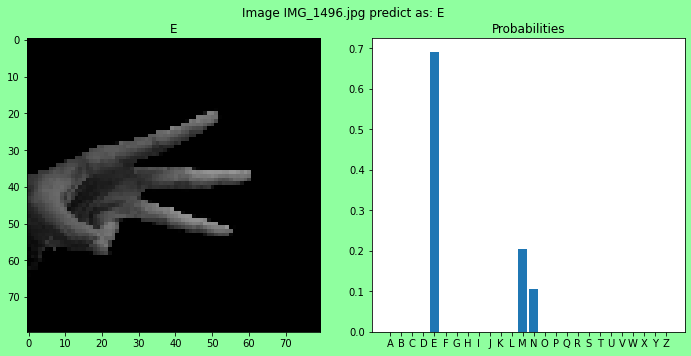

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

# predicting images
file_path, file_name, label = selectRandomImage()
# file_path, file_name, label = selectImageByLabel('L')
img = image.load_img(file_path, target_size = INPUT_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

prediction = model.predict(x, batch_size = 10)[0] # Predict Image
index = int(prediction.argmax(axis = -1)) # Get max classes index

# Result Plot
createResultPlot(prediction.reshape(NUM_CLASSES), LABELS[index], label, file_name)

In [119]:
# Save model
model.save(os.path.join(os.getcwd(), 'models','hand-sign-bisindo-model-inception(80x80).h5'))